In [32]:
#Import Dependencies
from functions import regress
from functions import linregress
from functions import summarize
import pandas as pd
#Dependencies
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, BiScaler
import pandas as pd
import sklearn
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import numpy as np

<h2>Get the Data</h2>


In [33]:
#Convert data from Stata format to pandas dataframe
gss = pd.io.stata.read_stata('../data/GSS1996.dta',convert_categoricals=False)
itr = pd.read_stata('../data/GSS1996.dta', iterator = True)
gss.to_csv('../data/gss_converted.csv')

<h2>Clean the Data</h2>

In [34]:
#Drop all instances where no vehicle was purchased
gss=gss.dropna(subset=["carprivt"])

In [35]:
#Get list of relevant variable names
full_list=list(gss)
varlist=[]
for item in full_list:
    if item[0:3]=="car":
     varlist.append(item)

morevars=["degree","region","race","childs","sex","marital","satcar","newused", "age"]
for item in morevars:
    varlist.append(item)

In [36]:
#Get varaible labels
labels=itr.variable_labels()
for item in varlist:
    print(f"{item}: {labels[item]}")

carprivt: have you purchased a used car past 5 yrs?
cardealr: purchased a car from a dealership past 5 yrs?
carbuyf: r searched for the best price
carbuya: r's own previous knowledge made r buy
carbuyg: convenience made r buy 
carbuyd: general reputation made r buy
carbuyb: a friend or relative recommended r buy 
carbuyc: an acquaintance recommended r buy
carbuye: r saw their advertisement
carbuy1: what was the most important reason? 
degree: r's highest degree
region: region of interview
race: race of respondent
childs: number of children
sex: respondents sex
marital: marital status
satcar: how satisfied are you with your purchase? 
newused: was the car new or used?
age: age of respondent


In [37]:
#Recode the Variables

#Car Variables
dummylist = ["carprivt", "cardealr", "carbuyf", "carbuya", "carbuyg", "carbuyd", "carbuyb", "carbuyc", "carbuye", "carbuy1","satcar", "newused"]
for item in dummylist:
    gss[f"{item}_r"]=gss[item]
    gss.loc[(gss[item] ==1), f"{item}_r"] = 0
    gss.loc[(gss[item] ==2), f"{item}_r"] = 1

#Control Variables
#Recode sex to dummy, reference category = "female"
gss["sex_r"]=gss["sex"]
gss.loc[gss.sex == 1, 'sex_r'] = 0
gss.loc[gss.sex == 2, 'sex_r'] = 1

#Recode race to dummy, reference category = "nonwhite"
gss["race_r"]=gss["race"]
gss.loc[gss.race == 1, 'race_r'] = 0
gss.loc[gss.race > 1, 'race_r'] = 1

#Recode degree to dummy, reference category = "has no degree" (note that in original study, ref cat was HAS degree)
gss["degree_r"]=gss["degree"]
gss.loc[gss.degree <=3, 'degree_r'] = 0
gss.loc[gss.degree > 3, 'degree_r'] = 1

#Recode region to dummy, reference category = "Not from South"
gss["region_r"]=gss["region"]
gss.loc[(gss.region <=4) | (gss.region >7), 'region_r'] = 0
gss.loc[(gss.region >=5) & (gss.region <=7), 'region_r'] = 1

#Recode marital to new categorical variable with reference category = "single, never married" and divorced and separated categories combined (note that this differs slightly from the original study, which did not assign "0" to any value of the variable.)
#New categories:
#0=single, never married
#1=married
#2=divorced/separated
#3=widowed
gss["marital_r"]=gss["marital"]
gss.loc[(gss.marital ==5), 'marital_r'] = 0
gss.loc[(gss.marital ==4) | (gss.marital ==3), 'marital_r'] = 2
gss.loc[(gss.marital ==3), 'marital_r'] = 3

#Recode parent to dummy, reference category = "is not parent"
gss["childs_r"]=gss["childs"]
gss.loc[(gss.childs >0), 'childs_r'] = 1

#Center the age variable
gss["age_c"]=gss["age"]-gss["age"].mean()

In [38]:
newvars=['carprivt_r', 'cardealr_r', 'carbuyf_r', 'carbuya_r', 'carbuyg_r', 'carbuyd_r', 'carbuyb_r', 'carbuyc_r', 'carbuye_r', 'carbuy1_r', 'degree_r', 'region_r', 'race_r', 'childs_r', 'sex_r', 'marital_r', 'satcar_r', 'newused_r', 'age_c']
reduced=pd.DataFrame()
for item in newvars:
    reduced[item]=gss[item]

In [39]:
gone=reduced["marital_r"].dropna()

In [40]:
gone

1       0.0
5       2.0
12      0.0
13      3.0
20      3.0
       ... 
2898    2.0
2899    0.0
2900    1.0
2901    3.0
2903    1.0
Name: marital_r, Length: 735, dtype: float64

In [41]:
def summarize(dataframe,variable):
    #dependencies
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    #define arguments
    dfvar=dataframe[variable]
    description=dfvar.describe()
    print(description)
    print("\n")
    checkvar=dfvar.dropna()
    if (checkvar % 1  == 0).all()== True and len(set(checkvar))<10:
        cats=set(checkvar)
        print("Obs per category")
        print("------------------")
        for item in cats:
           count=len(dataframe.loc[dfvar == item])
           percent=round(count/len(dfvar)*100, 2)
           print(f"{item}-> {count} ({percent}%)")
        values=list(set(checkvar))
        marks= len(values)
        hist=plt.hist(dfvar, bins=len(values))
        plt.xticks(ticks=values)
        plt.savefig(f"../figures/Histogram_{variable}.png")
        plt.show()
        print(hist)
    else:
        hist=plt.hist(dfvar, bins=10)
        plt.savefig(f"../figures/Histogram_{variable}.png")
        plt.show()
        print(hist)




CARPRIVT_R



count    735.000000
mean       0.659864
std        0.474077
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carprivt_r, dtype: float64


Obs per category
------------------
0.0-> 250 (34.01%)
1.0-> 485 (65.99%)


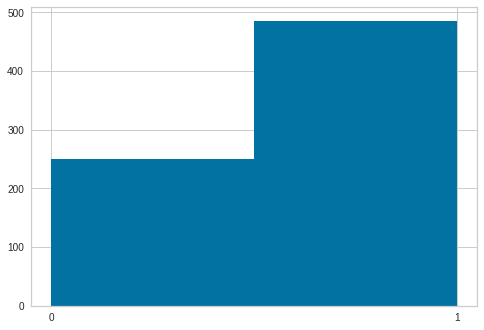

(array([250., 485.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARDEALR_R



count    728.000000
mean       0.451923
std        0.498025
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: cardealr_r, dtype: float64


Obs per category
------------------
0.0-> 399 (54.29%)
1.0-> 329 (44.76%)


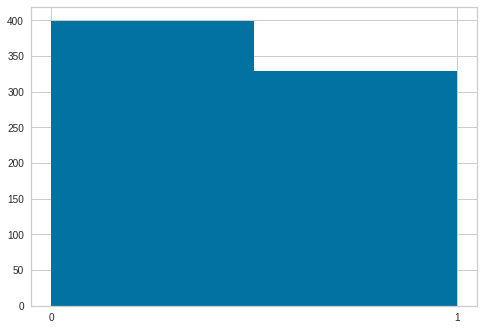

(array([399., 329.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYF_R



count    334.000000
mean       0.497006
std        0.500741
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: carbuyf_r, dtype: float64


Obs per category
------------------
0.0-> 168 (22.86%)
1.0-> 166 (22.59%)


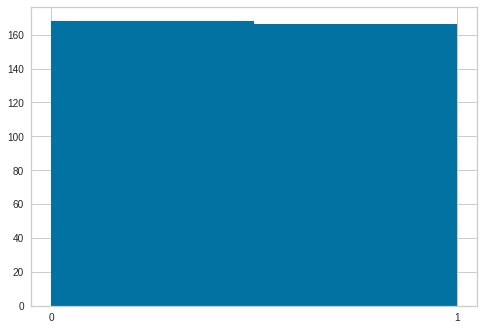

(array([168., 166.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYA_R



count    330.000000
mean       0.612121
std        0.488007
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuya_r, dtype: float64


Obs per category
------------------
0.0-> 128 (17.41%)
1.0-> 202 (27.48%)


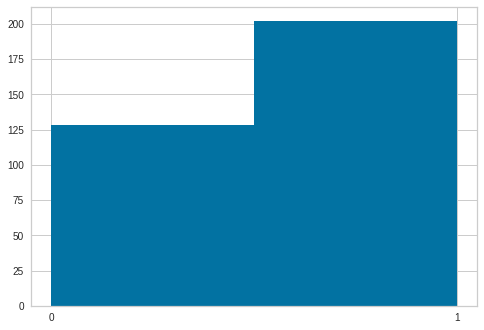

(array([128., 202.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYG_R



count    324.000000
mean       0.626543
std        0.484470
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuyg_r, dtype: float64


Obs per category
------------------
0.0-> 121 (16.46%)
1.0-> 203 (27.62%)


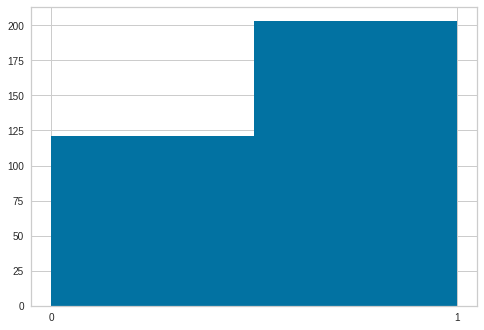

(array([121., 203.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYD_R



count    316.000000
mean       0.661392
std        0.473987
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuyd_r, dtype: float64


Obs per category
------------------
0.0-> 107 (14.56%)
1.0-> 209 (28.44%)


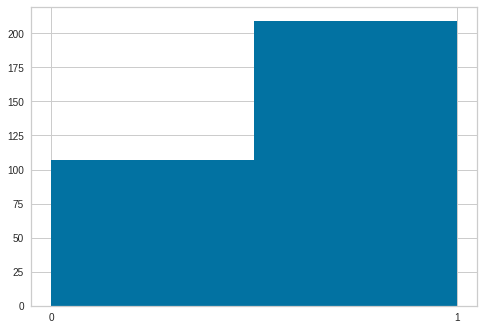

(array([107., 209.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYB_R



count    315.000000
mean       0.647619
std        0.478472
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuyb_r, dtype: float64


Obs per category
------------------
0.0-> 111 (15.1%)
1.0-> 204 (27.76%)


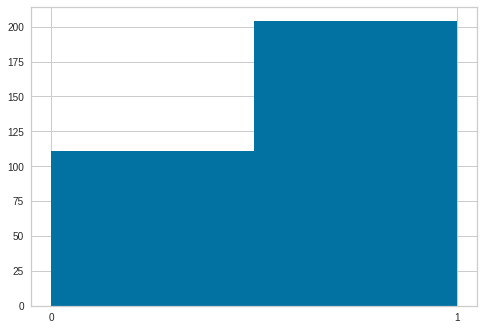

(array([111., 204.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYC_R



count    305.000000
mean       0.875410
std        0.330796
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuyc_r, dtype: float64


Obs per category
------------------
0.0-> 38 (5.17%)
1.0-> 267 (36.33%)


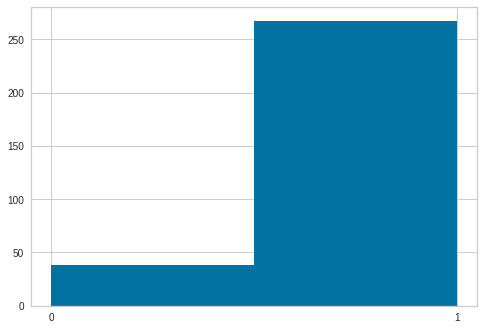

(array([ 38., 267.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUYE_R



count    305.000000
mean       0.740984
std        0.438815
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: carbuye_r, dtype: float64


Obs per category
------------------
0.0-> 79 (10.75%)
1.0-> 226 (30.75%)


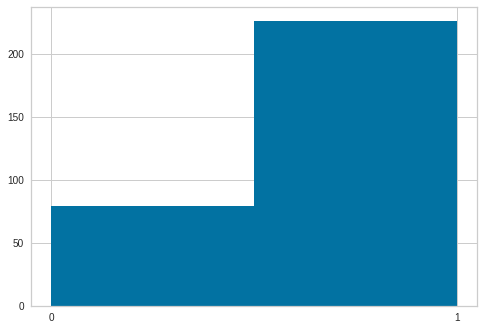

(array([ 79., 226.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CARBUY1_R



count    186.000000
mean       3.994624
std        2.587908
min        0.000000
25%        1.000000
50%        5.500000
75%        6.000000
max        7.000000
Name: carbuy1_r, dtype: float64


Obs per category
------------------
0.0-> 35 (4.76%)
1.0-> 23 (3.13%)
3.0-> 5 (0.68%)
4.0-> 20 (2.72%)
5.0-> 10 (1.36%)
6.0-> 76 (10.34%)
7.0-> 17 (2.31%)


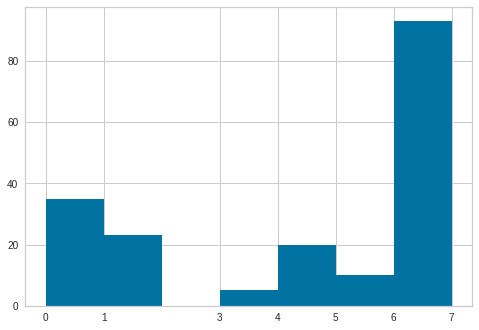

(array([35., 23.,  0.,  5., 20., 10., 93.]), array([0., 1., 2., 3., 4., 5., 6., 7.]), <BarContainer object of 7 artists>)



DEGREE_R



count    731.000000
mean       0.073871
std        0.261741
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: degree_r, dtype: float64


Obs per category
------------------
0.0-> 677 (92.11%)
1.0-> 54 (7.35%)


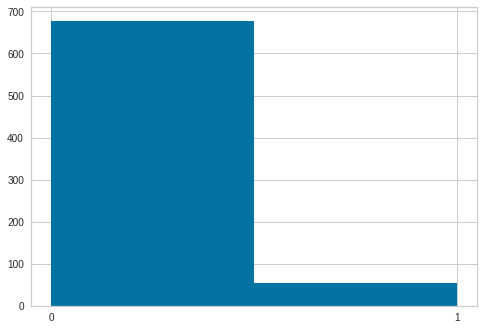

(array([677.,  54.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



REGION_R



count    735.000000
mean       0.346939
std        0.476320
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: region_r, dtype: float64


Obs per category
------------------
0-> 480 (65.31%)
1-> 255 (34.69%)


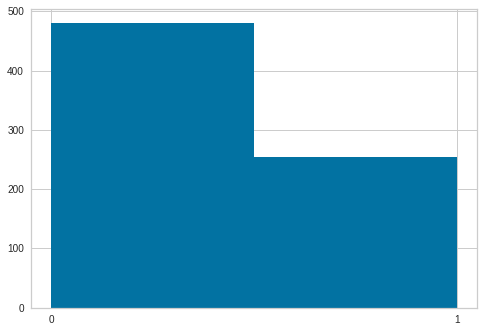

(array([480., 255.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



RACE_R



count    735.000000
mean       0.200000
std        0.400272
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: race_r, dtype: float64


Obs per category
------------------
0-> 588 (80.0%)
1-> 147 (20.0%)


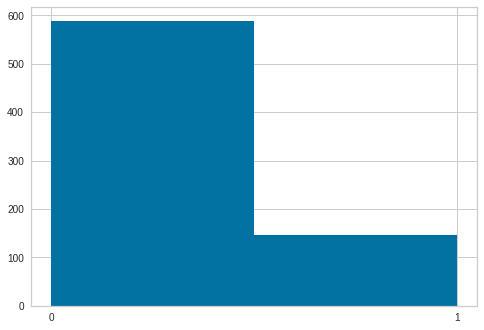

(array([588., 147.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



CHILDS_R



count    731.000000
mean       0.715458
std        0.451505
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: childs_r, dtype: float64


Obs per category
------------------
0.0-> 208 (28.3%)
1.0-> 523 (71.16%)


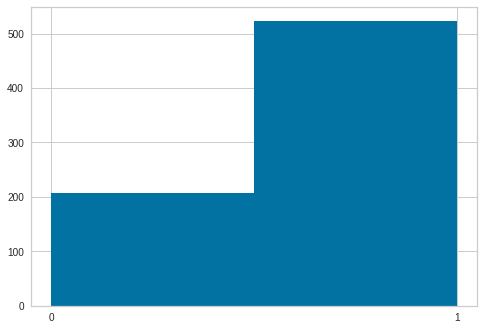

(array([208., 523.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



SEX_R



count    735.000000
mean       0.538776
std        0.498834
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: sex_r, dtype: float64


Obs per category
------------------
0-> 339 (46.12%)
1-> 396 (53.88%)


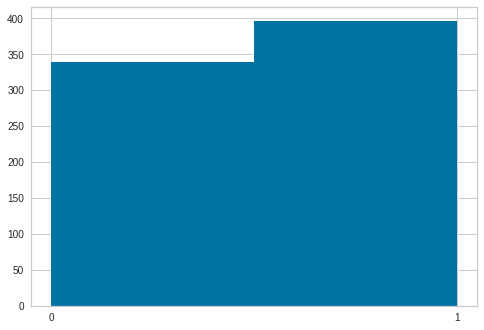

(array([339., 396.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



MARITAL_R



count    735.000000
mean       1.221769
std        0.971566
min        0.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        3.000000
Name: marital_r, dtype: float64


Obs per category
------------------
0.0-> 165 (22.45%)
1.0-> 360 (48.98%)
2.0-> 92 (12.52%)
3.0-> 118 (16.05%)


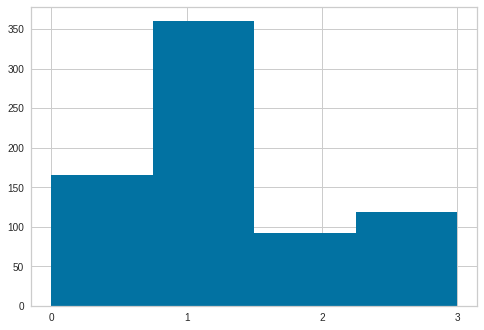

(array([165., 360.,  92., 118.]), array([0.  , 0.75, 1.5 , 2.25, 3.  ]), <BarContainer object of 4 artists>)



SATCAR_R



count    396.000000
mean       1.934343
std        1.127665
min        0.000000
25%        1.000000
50%        3.000000
75%        3.000000
max        3.000000
Name: satcar_r, dtype: float64


Obs per category
------------------
0.0-> 36 (4.9%)
1.0-> 157 (21.36%)
3.0-> 203 (27.62%)


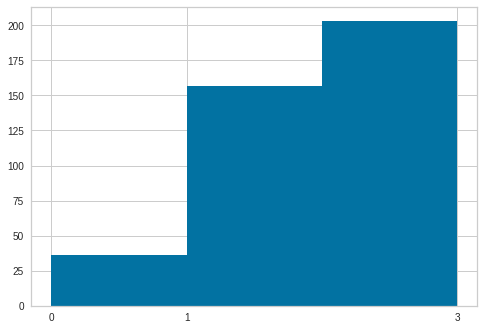

(array([ 36., 157., 203.]), array([0., 1., 2., 3.]), <BarContainer object of 3 artists>)



NEWUSED_R



count    400.000000
mean       0.477500
std        0.500119
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: newused_r, dtype: float64


Obs per category
------------------
0.0-> 209 (28.44%)
1.0-> 191 (25.99%)


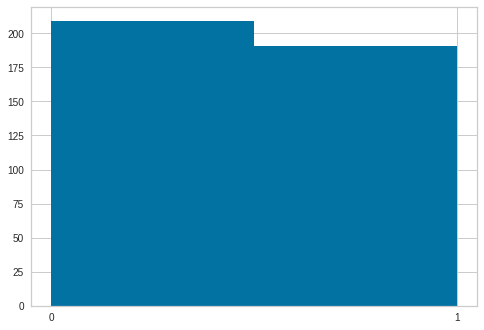

(array([209., 191.]), array([0. , 0.5, 1. ]), <BarContainer object of 2 artists>)



AGE_C



count    7.350000e+02
mean    -1.759439e-15
std      1.697333e+01
min     -2.699864e+01
25%     -1.299864e+01
50%     -2.998639e+00
75%      1.100136e+01
max      4.400136e+01
Name: age_c, dtype: float64




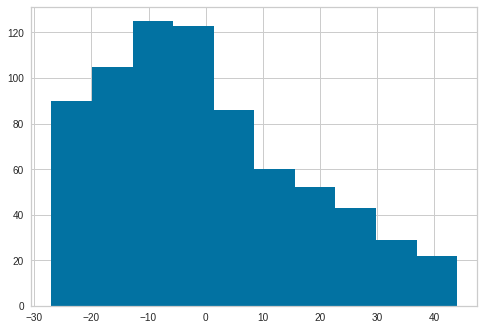

(array([ 90., 105., 125., 123.,  86.,  60.,  52.,  43.,  29.,  22.]), array([-26.99863946, -19.89863946, -12.79863946,  -5.69863946,
         1.40136054,   8.50136054,  15.60136054,  22.70136054,
        29.80136054,  36.90136054,  44.00136054]), <BarContainer object of 10 artists>)


In [42]:
#Get summary statistics and histogram for all variables
for item in newvars:
    print("\n"*2)
    print(item.upper())
    print("\n"*2)
    summarize(reduced, item)

In [43]:
import seaborn as sns
import pandas as pd
import statsmodels.api as sm
import numpy as np

In [ ]:
#multiply impute the data to prep it for logistic regression analysis)
reduced_copy=reduced.copy(deep=True)
X_filled_knn = KNN(k=3).fit_transform(reduced_copy)
reduced_mi=pd.DataFrame(X_filled_knn, columns=reduced_copy.columns)
reduced_mi.to_csv("../data/reduced_mi.csv")

In [44]:
model = sm.GLM.from_formula("carprivt_r ~ sex_r", family = sm.families.Binomial(), data=reduced)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:             carprivt_r   No. Observations:                  735
Model:                            GLM   Df Residuals:                      733
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -467.41
Date:                Fri, 26 Mar 2021   Deviance:                       934.83
Time:                        00:47:36   Pearson chi2:                     735.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4375      0.111      3.933      0.000       0.220       0.656
sex_r          0.4315      0.157      2.757      0.006       0.125       0.738
==============================================================================
"""

In [61]:
linregress(reduced, "carprivt_r", "sex_r", "race_r", "marital_r", "carbuya_r")

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
gss_k3=gss_recoded.copy(deep=True)
X_filled_knn = KNN(k=3).fit_transform(gss_k3)
gss_knn=pd.DataFrame(X_filled_knn, columns=gss_recoded.columns)
gss_knn.to_csv("../data/gss_fancyimpute_knn.csv")